## **DeepFlix**: A Neural Network for TV Rating Classification

In [1]:
# All Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
# Loading the Dataset
df = pd.read_csv('netflix.csv')
df.head()
print(df.shape)

(8807, 12)


## Project Goal
##### The goal of this project is to build and evaluate a neural network that can classify a Netflix show or movie into a content rating category ('Kids', 'Teens', or 'Adult') based on its metadata.

In [3]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
df.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [6]:
df['rating'].unique() # too many rating categories, can cause accuracy problems

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR'], dtype=object)

In [7]:
df['rating'].value_counts()

rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='count'>

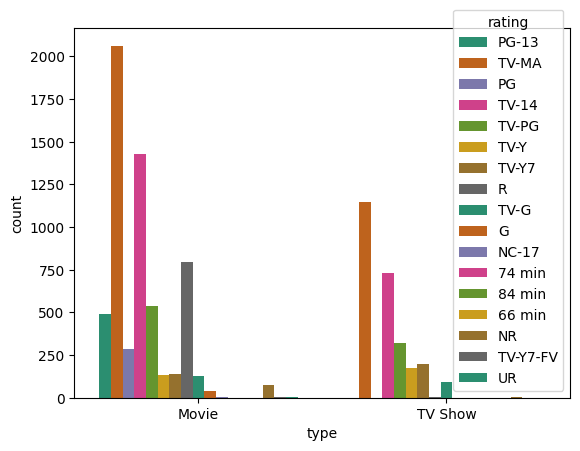

In [13]:
sns.countplot(data=df, x='type', hue='rating', palette='Dark2')

## Data Cleaning & Target Engineering
##### The raw rating column has 14 unique values, is highly imbalanced, and contains bad data (e.g., '74 min'). To create a cleaner, more balanced target variable for the model, I grouped these 14 ratings into 3 logical categories.

In [8]:
df = df.dropna(subset=['rating'])
df = df[~df['rating'].str.contains('min', na=False)]
df = df.reset_index(drop=True)

In [9]:
def group_rating(rating):
    if rating in ['TV-Y', 'TV-Y7', 'TV-G', 'G', 'TV-Y7-FV']:
        return 'Kids'
    elif rating in ['TV-PG', 'PG', 'TV-14', 'PG-13']:
        return 'Teens'
    else: # 'TV-MA', 'R', 'NC-17', 'UR', 'NR'
        return 'Adult'

In [10]:
df['rating_group'] = df['rating'].apply(group_rating)
df['rating_group'].value_counts()

rating_group
Adult    4092
Teens    3800
Kids      908
Name: count, dtype: int64

In [11]:
nan_cols = ['director', 'cast', 'country', 'date_added']
df[nan_cols] = df[nan_cols].fillna('Unknown')

In [12]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df[['year_added', 'month_added']] = df[['year_added', 'month_added']].fillna(0)

In [13]:
current_year = 2025
df['age_of_show'] = current_year - df['release_year']

In [14]:
df['age_of_show'].value_counts()

age_of_show
7      1147
8      1030
6      1030
5       953
9       902
       ... 
64        1
100       1
66        1
59        1
78        1
Name: count, Length: 74, dtype: int64

In [36]:
df['duration_num'] = df['duration'].str.extract(r'(\d+)').astype(float)
df['is_movie'] = df['type'].apply(lambda x: 1 if x == 'Movie' else 0)

In [16]:
# Only considering the first genre as it simplifies multi genre strings
df['genre'] = df['listed_in'].apply(lambda x: x.split(',')[0])

### Choosing the FEATURES and the LABEL

In [17]:
features = ['country','month_added', 'age_of_show', 'duration_num', 'is_movie', 'genre']
X = df[features]
y = df['rating_group']

In [18]:
X = pd.get_dummies(X, columns=['genre', 'country'], drop_first=True)

In [20]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Encoded Classes:", le.classes_)

Encoded Classes: ['Adult' 'Kids' 'Teens']


In [21]:
# Normalizes numeric data (mean=0, std=1) so the neural network learns faster.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [ ]:
# Convert labels to one-hot encoding for the neural network
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
num_classes = y_train_onehot.shape[1] 

### Building the Neural Network

In [38]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [25]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,299 (434.76 KB)

 Trainable params: 111,299 (434.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_onehot,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4737 - loss: 1.0269 - val_accuracy: 0.6065 - val_loss: 0.7471
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6137 - loss: 0.7724 - val_accuracy: 0.6541 - val_loss: 0.6989
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6489 - loss: 0.7051 - val_accuracy: 0.6506 - val_loss: 0.6876
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6651 - loss: 0.6674 - val_accuracy: 0.6527 - val_loss: 0.6871
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6906 - loss: 0.6373 - val_accuracy: 0.6577 - val_loss: 0.6842
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6827 - loss: 0.6354 - val_accuracy: 0.6683 - val_loss: 0.6863
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7008 - loss: 0.6146 - val_accuracy: 0.6726 - val_loss: 0.6859
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6968 - loss: 0.6133 - val_accuracy: 0.

### MODEL EVALUATION

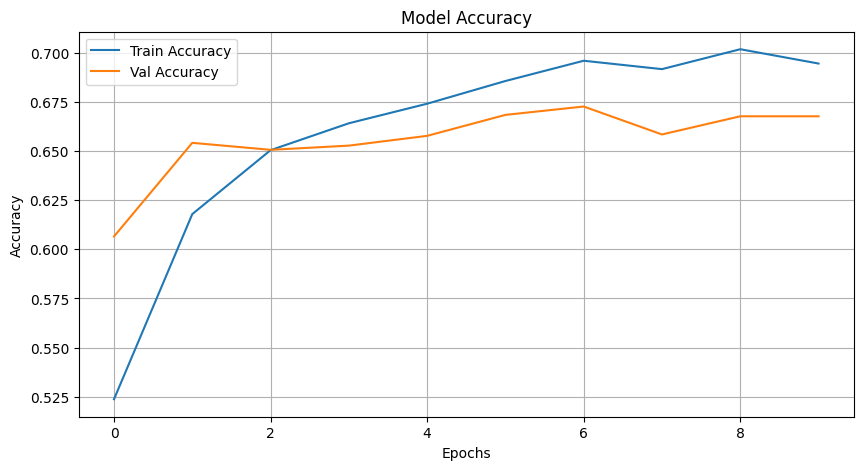

In [28]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('model_accuracy_plot.png') # Save the plot
plt.show()

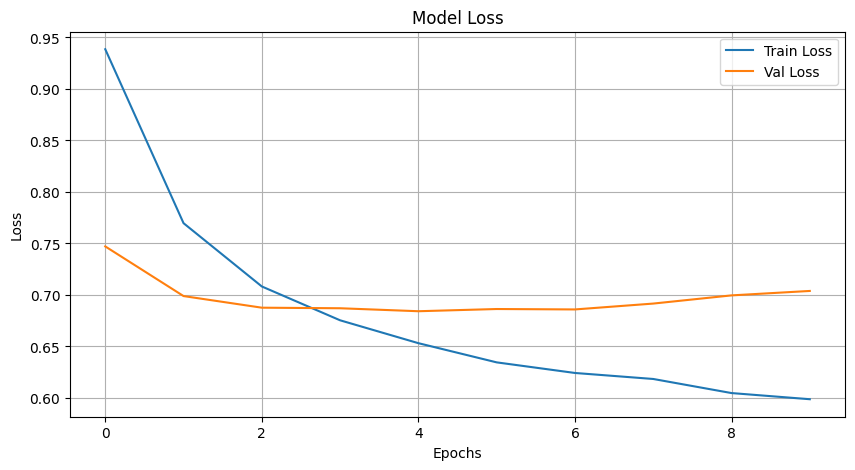

In [29]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('model_loss_plot.png') # Save the plot
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f"\nTest Accuracy: {test_acc:.3f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6314 - loss: 0.7483

Test Accuracy: 0.638


In [31]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
               precision    recall  f1-score   support

       Adult       0.64      0.69      0.66       818
        Kids       0.79      0.59      0.68       182
       Teens       0.61      0.60      0.60       760

    accuracy                           0.64      1760
   macro avg       0.68      0.62      0.65      1760
weighted avg       0.64      0.64      0.64      1760



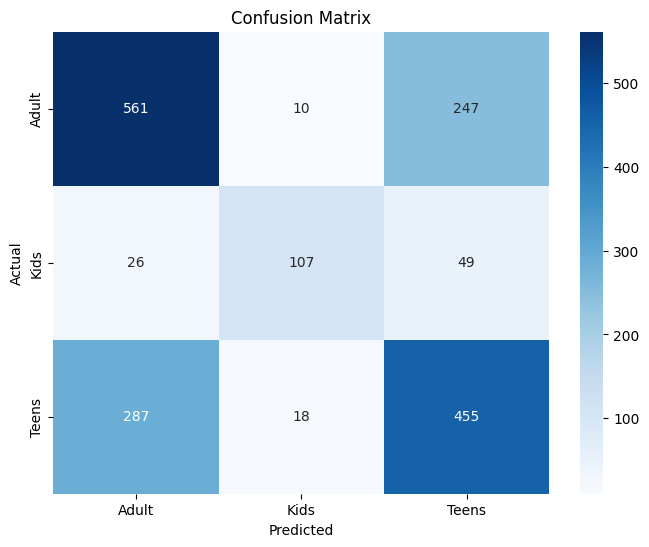

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png') # Save the plot
plt.show()

### The model achieved a test accuracy of 63.8%.

##### The classification report and confusion matrix show the model is very good at identifying 'Kids' content (79% precision) but struggles to differentiate between 'Teens' and 'Adults'. This is likely because the current features (like genre, duration, and country) are ambiguous. For example, an R-rated 'Adult' action movie and a PG-13 'Teens' action movie look very similar.

##### Future Improvement: The clear next step is to incorporate the text description column using TF-IDF. This will provide the model with the crucial keywords (e.g., "violence," "drug use") it needs to separate these two confused classes.

In [34]:
model.save("netflix_tv_rating_classifier.keras")